In [139]:
image = require 'image'
require 'nn'
require 'os'
require 'paths'
require 'optim'
require 'sys'

logger = optim.Logger('./logs/loss_log.txt')

os.execute('mkdir -p dataset logs models')

file exists	


 700
   3
  51
  51
[torch.LongStorage of size 4]

 132
   3
  51
  51
[torch.LongStorage of size 4]

 700
   3
 102
 102
[torch.LongStorage of size 4]

 132
   3
 102
 102
[torch.LongStorage of size 4]



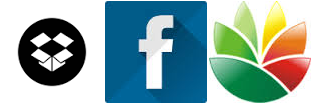

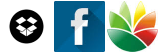

In [137]:

-- download dataset if necessary

function file_exists(name)
    local f=io.open(name,"r")
    if f~=nil then
        io.close(f)
        return true
    else
        return false
    end
end

if not file_exists('./dataset/images.t7') then
    print('downloading')
    os.execute('wget -c http://ml1.oss-cn-hongkong.aliyuncs.com/art/web/sr/dataset/images.t7.zip -O ./dataset/images.t7.zip')
    os.execute('unzip -o ./dataset/images.t7.zip -d ./dataset')
    print('downloaded and unzipped')
else
    print('file exists')
end


-- load dataset to a Tensor and generate low-resolution dataset

labels = torch.load("./dataset/images.t7")
m = labels:size()[1]
data = torch.Tensor(m, 3, 51, 51)
for i=1,m do
    data[i] = image.scale(labels[i], 51, 51)
end


-- divide dataset into train and validation

labels_train = labels[{{1,700,{},{},{}}}]
labels_validation = labels[{{701,m,{},{},{}}}]

data_train = data[{{1,700},{},{},{}}]
data_validation = data[{{701,m},{},{},{}}]

print(data_train:size(), data_validation:size())
print(labels_train:size(), labels_validation:size())


-- sample some images

itorch.image(labels[{{1,3}}])
itorch.image(data[{{1,3}}])


In [144]:

-- nn model and criterion

load_from_model = false
if load_from_model then
    model = torch.load('./models/model.t7')
else 
    model = nn.Sequential()
    model:add(nn.SpatialConvolution(3,16,3,3,1,1,1,1))
    model:add(nn.LeakyReLU(0.2))
    model:add(nn.SpatialFullConvolution(16, 3, 2, 2, 2, 2, 0, 0, 0, 0))
    model:add(nn.LeakyReLU(0.2))
    model:add(nn.View(3*102*102))
    model:add(nn.Tanh())
end

criterion = nn.MSECriterion()


In [145]:

-- torch.setnumthreads(4)
torch.manualSeed(0)

sgd_params = {
   learningRate = 1e-2,
   learningRateDecay = 1e-4,
   weightDecay = 0,
   momentum = 0
}

x, dl_params = model:getParameters()


-- feval function to be used for optim
function feval(x_new)

  if x ~= x_new then
    x:copy(x_new)
  end

  dl_params:zero()

  local outputs = model:forward(data_batch)
  local loss = criterion:forward(outputs, label_batch)
  local dloss_doutputs = criterion:backward(outputs, label_batch)
  model:backward(data_batch, dloss_doutputs)
  return loss, dl_params

end

-- minibatch settings
m = data_train:size()[1]
batch_size = 20
n_of_batches = math.floor(m/batch_size)

print('epoch', 'duration', 'loss')
for epoch = 1, 10 do

    current_loss = 0
    start_time = os.time()

--  mini-batch SGD
    for n=1,n_of_batches do
        start = batch_size * (n-1) + 1
        finish = batch_size * n
        data_batch = data_train[{{start,finish}}]
        label_batch = labels_train[{{start,finish}}]
        _, fs = optim.sgd(feval,x,sgd_params)
        current_loss = current_loss + (fs[1]/batch_size)
    end
    
    if epoch % 10 == 0 then

--      log results
        duration = os.time() - start_time
        duration = (duration)..'s'

        print(epoch, duration, current_loss)
        logger:add{['training error'] = current_loss}
        logger:style{['training error'] = '-'}
        logger:plot()

--      save model
        if epoch % 50 == 0 then
            torch.save('./models/model.t7', model)
            print('model saved')
        end

    end
end

epoch	duration	loss	


10	5s	0.010936045292194	


small image	


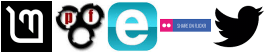

bicubic	


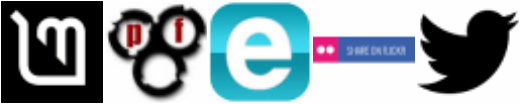

super resolution	


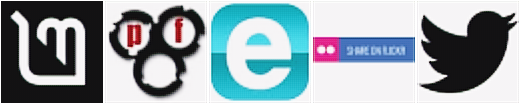

ground truth	


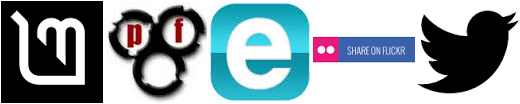

bicubic 4x	


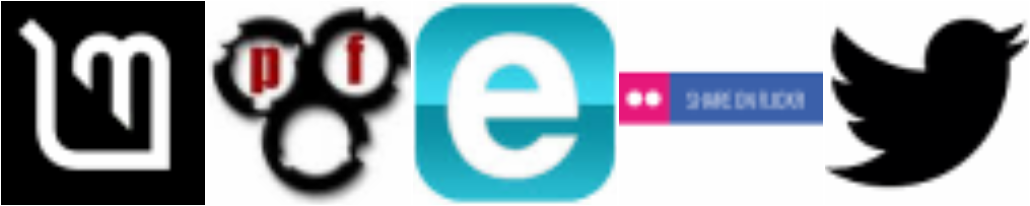

super resolution 4x	


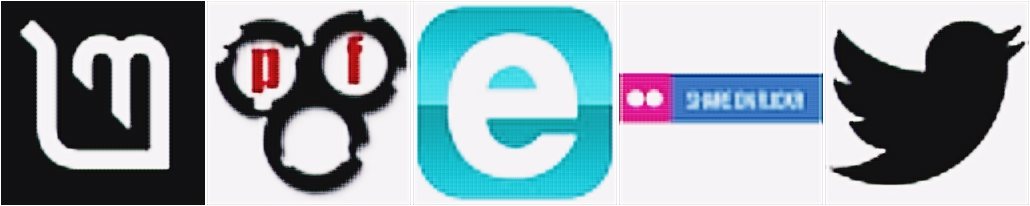

In [146]:

function validate(_fr, _to)
    
    local n_of_images = _to - _fr + 1
    
    small_images = data[{{_fr,_to}}]
    
    bicubic_scaled = torch.Tensor(n_of_images, 3, 102, 102)
    bicubic_scaled_4x = torch.Tensor(n_of_images, 3, 204, 204)
    for i=1,n_of_images do
        bicubic_scaled[i] = image.scale(small_images[i]:clone(), 102, 102)
        bicubic_scaled_4x[i] = image.scale(small_images[i]:clone(), 204, 204)
    end
    predicted = model:forward(small_images):resize(n_of_images,3,102,102):clone()
    predicted_4x = model:forward(predicted):resize(n_of_images,3,204,204):clone()

    ground_truth = labels[{{_fr,_to}}]
    
    print('small image')
    sys.sleep(0.1)
    itorch.image(small_images)
    sys.sleep(0.1)
    
    print('bicubic')
    sys.sleep(0.1)
    itorch.image(bicubic_scaled)
    sys.sleep(0.1)
 
    print('super resolution')
    sys.sleep(0.1)
    itorch.image(predicted)
    sys.sleep(0.1)
    
    print('ground truth')
    sys.sleep(0.1)
    itorch.image(ground_truth)
    sys.sleep(0.1)
    
    print('bicubic 4x')
    sys.sleep(0.1)
    itorch.image(bicubic_scaled_4x)
    sys.sleep(0.1)

    print('super resolution 4x')
    sys.sleep(0.1)
    itorch.image(predicted_4x)
    
end

validate(705, 709)


small image	


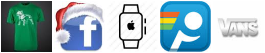

bicubic	


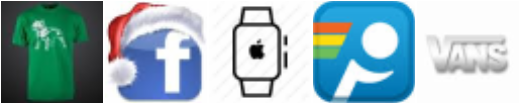

super resolution	


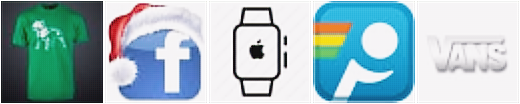

ground truth	


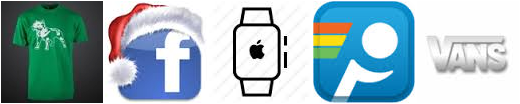

bicubic 4x	


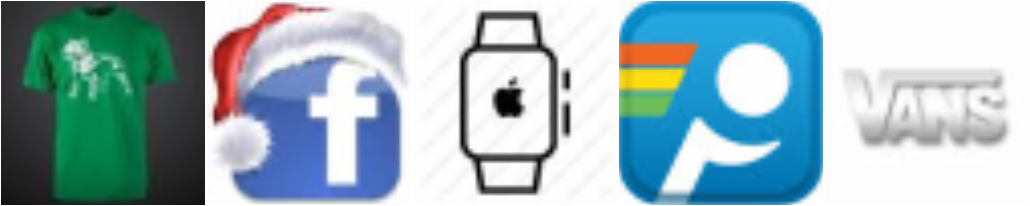

super resolution 4x	


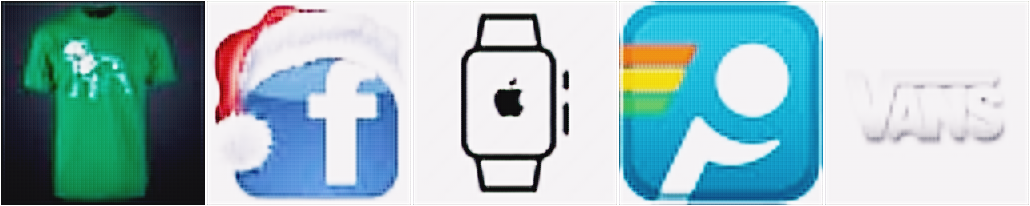

In [147]:
validate(800, 804)

small image	


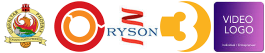

bicubic	


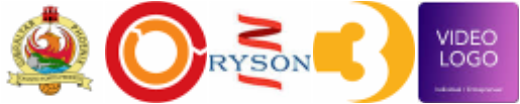

super resolution	


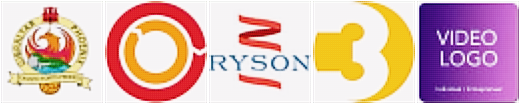

ground truth	


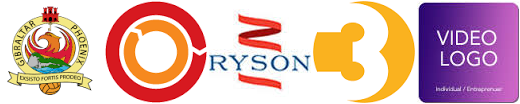

bicubic 4x	


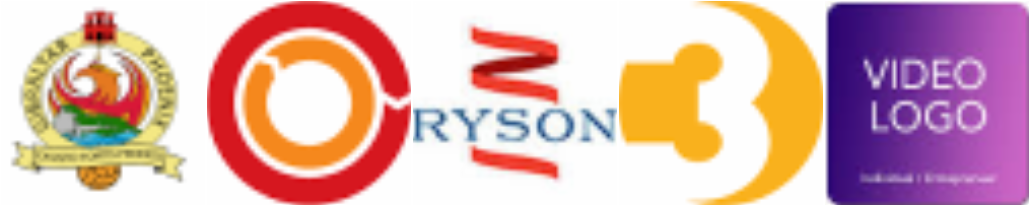

super resolution 4x	


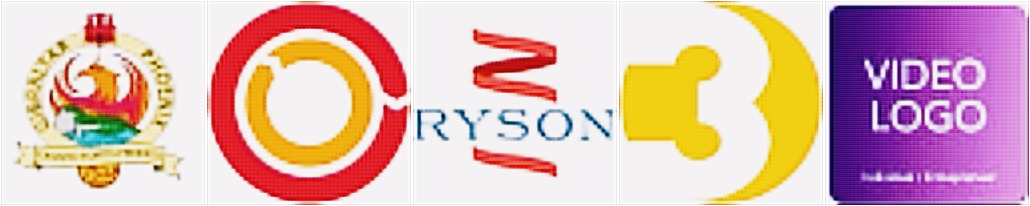

In [148]:
validate(806, 810)